#немного теории

<font color='blue' size=5>Метод максимального правдоподобия (ММП)

Метод максимального правдоподобия (ММП) является одним из наиболее распространенных методов оценки параметров статистических моделей. Основная идея метода заключается в нахождении таких значений параметров модели, при которых вероятность (правдоподобие) наблюдаемых данных максимальна.


1. Формулировка модели и выбор функции правдоподобия:  

Пусть $ X = (X_1, X_2, \ldots, X_n) $ — выборка из некоторого распределения, зависящего от неизвестного параметра $\theta$.
Функция плотности или функция вероятности наблюдений будет зависеть от $\theta$: $ f(X_i | \theta) $.

2. Запись функции правдоподобия:
$$L(\theta | X) = \prod_{i=1}^{n} f(X_i | \theta).$$

3. Логарифм функции правдоподобия:
$$\ell(\theta | X) = \log L(\theta | X) = \sum_{i=1}^{n} \log f(X_i | \theta).$$

4. Нахождение оценок параметров:
$$\hat{\theta} = \arg\max_{\theta} \ell(\theta | X).$$
   
$$\frac{\partial \ell(\theta | X)}{\partial \theta} = 0.$$

Рассмотрим простейший пример: оценка параметра $\mu$ нормального распределения с известной дисперсией $\sigma^2$.

1. Формулировка модели:
Пусть $X_1, X_2, \ldots, X_n$ — независимые и идентично распределенные случайные величины, $X_i \sim N(\mu, \sigma^2)$. Функция плотности вероятности:
$f(x | \mu) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right).$

2. Функция правдоподобия:
$$L(\mu | X) = \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(X_i - \mu)^2}{2\sigma^2}\right).$$

3. Логарифм функции правдоподобия:
$$\ell(\mu | X) = \sum_{i=1}^{n} \log \left(\frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(X_i - \mu)^2}{2\sigma^2}\right)\right) = -\frac{n}{2} \log(2 \pi \sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (X_i - \mu)^2.
$$

4. Максимизация логарифма функции правдоподобия:
Вычисляем производную по $\mu$ и приравниваем к нулю:
$$ \frac{\partial \ell(\mu | X)}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^{n} (X_i - \mu) = 0.$$

Решаем это уравнение:
$$\hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} X_i.$$
Таким образом, оценка параметра $\mu$ методом максимального правдоподобия — это среднее значение выборки.

Метод максимального правдоподобия является мощным инструментом для статистического анализа и широко используется в различных областях, включая эконометрику, биостатистику и машинное обучение.

# Практика

In [1]:
import pandas as pd
import numpy as np



# from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import (precision_score, recall_score,
                             roc_auc_score, roc_curve, f1_score)

from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, train_test_split)

# from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt




# Функции

In [2]:
def analyze_outliers(df, col):
  '''поиск выбросов с помощью IQR'''
  Q3 = np.quantile(df[col], 0.75, axis=0)
  Q1 = np.quantile(df[col], 0.25, axis=0)
  IQR = Q3 - Q1
  upper = round(Q3 + 1.5 * IQR, 2)
  lower = round(Q1 - 1.5 * IQR, 2)
  if round(Q1 - 1.5 * IQR, 2)<0:
    lower = 0
  print('____________________________________________________________________')
  print(f'интервал фактических значений для переменной {col} от {round(df[col].min(),2)} до {round(df[col].max(),2)}')
  print(f'интервал нормальных значений для переменной {col} от {lower} до {upper}')

  print(f'переменная {col} содержит аномальных значений : {round(df[(df[col]>upper)| (df[col]<lower)].shape[0]/df.shape[0]*100, 2)}%')

  if df[(df[col] == 0)].shape[0]>0:
    print(f'переменная {col} содержит нулевые значения {round(df[(df[col] == 0)].shape[0]/df.shape[0]*100, 2)}%')

  return lower, upper

In [3]:
def calc_optimal_cutoff(y_pred, y_fact):
  # Найдем оптимальный порог
  f1_scores = []
  thresholds = np.linspace(0, 1, num=100)
  for threshold in thresholds:
    y_pred_thresholded = (y_pred >= threshold).astype(int)

    f1 = f1_score(y_fact, y_pred_thresholded)
    # print('y_pred_thresholded')
    f1_scores.append(f1)

# Находим индекс максимальной F1
  best_f1_index = np.argmax(f1_scores)
  best_threshold = thresholds[best_f1_index]
  print("Оптимальный порог:", best_threshold)
  print("Максимальная F1-мера:", f1_scores[best_f1_index])

  return best_threshold

In [4]:
# Функция для расчета метрик и построения кривой ROC
def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Предсказание на обучающей и тестовой выборке
    y_train_proba = model.predict_proba(X_train)[:,1]

    best_threshold = calc_optimal_cutoff(y_train_proba, y_train)

    y_train_pred = (y_train_proba >= best_threshold).astype(int)
    y_test_proba = model.predict_proba(X_test)[:,1]
    y_test_pred = (y_test_proba >= best_threshold).astype(int)

    # Расчет метрик precision и recall
    train_precision = precision_score(y_train, y_train_pred)
    print(train_precision)
    train_recall = recall_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)

    print(f"Training Precision: {train_precision:.2f}")
    print(f"Training Recall: {train_recall:.2f}")
    print(f"Test Precision: {test_precision:.2f}")
    print(f"Test Recall: {test_recall:.2f}")

    metrics =  {'params': ['Training_Precision', 'Test_Precision','Training_Recall', 'Test_Recall'],
                'values': [train_precision, test_precision, train_recall, test_recall]}

    # Расчет ROC-AUC на тестовой выборке
    try:
      pred_test = model.predict_proba(X_test)
      pred_train = model.predict_proba(X_train)
      roc_auc_test = roc_auc_score(y_test, pred_test[:, 1])
      roc_auc_train = roc_auc_score(y_train, pred_train[:, 1])
      print(f"ROC-AUC_test = : {roc_auc_test:.2f} и ROC-AUC_train = : {roc_auc_train:.2f}")

      # Построение кривой ROC
      fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
      fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
      plt.figure()
      plt.plot(fpr_test, tpr_test, color='blue', lw=2, label = 'ROC Curve test')
      plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label = 'ROC Curve test')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend()
      plt.title(f'ROC Curve ({type(model).__name__})')
      plt.show()
    except Exception as e:
      print(e)
      roc_auc_test = 0
      roc_auc_train = 0

    metrics =  {'params': ['Training_Precision', 'Test_Precision','Training_Recall',
                           'Test_Recall', 'roc_auc_train', 'roc_auc_test'],
                'values': [train_precision, test_precision, train_recall,
                           test_recall, roc_auc_train, roc_auc_test]}
    return metrics

# Загрузка данных

In [5]:
sample = 2

"Heart Disease" из UCI Machine Learning Repository содержит информацию о пациентах и их медицинских показателях, задача состоит в предсказании наличия или отсутствия сердечных заболеваний.

In [6]:
if sample == 1:
  #  Загрузка набора данных Heart Disease
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
  column_names = [
      "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang",
      "oldpeak", "slope", "ca", "thal", "target"
  ]

  df = pd.read_csv(url, header=None, names=column_names, na_values="?")
  df.dropna(inplace=True)

  # Преобразование целевой переменной: 0 - отсутствие заболевания, 1 - наличие заболевания
  df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

## 2-ой набор

Набор данных "Adult" из UCI Machine Learning Repository, который также известен как "Census Income" dataset. Этот набор данных содержит информацию о доходах людей на основе демографических данных и позволяет решить задачу бинарной классификации, предсказывая, зарабатывает ли человек более или менее 50K в год.

In [7]:
if sample == 2:
  # Загрузка набора данных Adult
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
  columns = [
      "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
      "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
      "hours-per-week", "native-country", "income"
  ]

  df = pd.read_csv(url, header=None, names=columns, na_values=" ?", sep=',\s', engine='python')

  # Удаление строк с пропущенными значениями
  df.dropna(inplace=True)

  # Преобразование целевой переменной: <=50K - 0, >50K - 1
  df['target'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)


## Выбор признаков и целевой переменной

In [8]:
df = df.select_dtypes(include='number')

In [9]:

X = df.drop('target', axis=1)
y = df['target']

In [10]:
df.shape

(32561, 7)

In [11]:
df.dtypes

age               int64
fnlwgt            int64
education-num     int64
capital-gain      int64
capital-loss      int64
hours-per-week    int64
target            int64
dtype: object

# Разделим данные

In [12]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Подготовка данных и построение модели

In [13]:
# Стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Построение моделей

## KNN

In [14]:
knn_model = KNeighborsClassifier()

In [15]:
%%time
# Задаем сетку параметров для значения "n_neighbors", которое мы хотим исследовать
param_grid = {'n_neighbors': [3, 5, 7, 9, ], 'p':[1,2]}  # Пример значений, можно изменить диапазон по необходимости

# Создаем объект GridSearchCV с моделью KNN и сеткой параметров
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='roc_auc')  # Параметр cv определяет количество фолдов в кросс-валидации

# Обучаем модель на данных с помощью кросс-валидации
grid_search.fit(X_train_scaled, y_train)

# Получаем лучшее найденное значение параметра "n_neighbors" в результате кросс-валидации
grid_search.best_params_



CPU times: user 22.9 s, sys: 193 ms, total: 23.1 s
Wall time: 38.1 s


{'n_neighbors': 9, 'p': 1}

In [16]:
best_knn_model = KNeighborsClassifier(**grid_search.best_params_)
best_knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=9, p=1)

In [17]:
y_pred_test = best_knn_model.predict_proba(X_test_scaled)[:,1]

Оптимальный порог: 0.22222222222222224
Максимальная F1-мера: 0.6596920647453612
0.561491935483871
Training Precision: 0.56
Training Recall: 0.80
Test Precision: 0.49
Test Recall: 0.70
ROC-AUC_test = : 0.81 и ROC-AUC_train = : 0.89


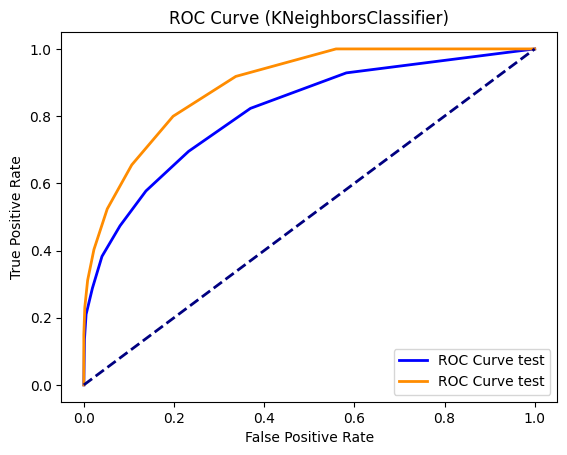

In [18]:
metrics_knn = calculate_metrics_and_plot_roc(best_knn_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Лог рег

In [19]:
%%time
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30, 50, 100],
              'penalty': ['l2','l1',],
              # 'solver': ['liblinear','saga']
              }

# Создаем модель логистической регрессии
logreg_model = LogisticRegression(solver='saga', max_iter = 100000)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(logreg_model,
                           param_grid,
                           cv=5,
                           scoring='roc_auc')  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train_scaled, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


Лучшее значение параметра: {'C': 0.1, 'penalty': 'l2'}
CPU times: user 8.71 s, sys: 5.53 s, total: 14.2 s
Wall time: 9.02 s


In [20]:
%%time
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30, 50, 100],
              'penalty': ['l2', 'l1'],
              # 'solver': ['liblinear', 'saga']
              }

# Создаем модель логистической регрессии
logreg_model = LogisticRegression(solver='saga', max_iter=100000)

# Создаем объект RandomizedSearchCV с моделью логистической регрессии и сеткой параметров
random_search = RandomizedSearchCV(logreg_model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=5, scoring='roc_auc')

# Обучаем модель на данных с использованием кросс-валидации
random_search.fit(X_train_scaled, y_train)

# Получаем лучшее значение параметров, найденных в процессе кросс-валидации
print('Лучшие значения параметров:', random_search.best_params_)


Лучшие значения параметров: {'penalty': 'l2', 'C': 0.1}
CPU times: user 5.49 s, sys: 3.86 s, total: 9.35 s
Wall time: 5.13 s


In [21]:

# Построение модели логистической регрессии
best_logreg_model = LogisticRegression(solver='saga',  max_iter=1000, **grid_search.best_params_)
best_logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='saga')

Оптимальный порог: 0.29292929292929293
Максимальная F1-мера: 0.5897511848341233
0.550456179153995
Training Precision: 0.55
Training Recall: 0.64
Test Precision: 0.55
Test Recall: 0.65
ROC-AUC_test = : 0.84 и ROC-AUC_train = : 0.83


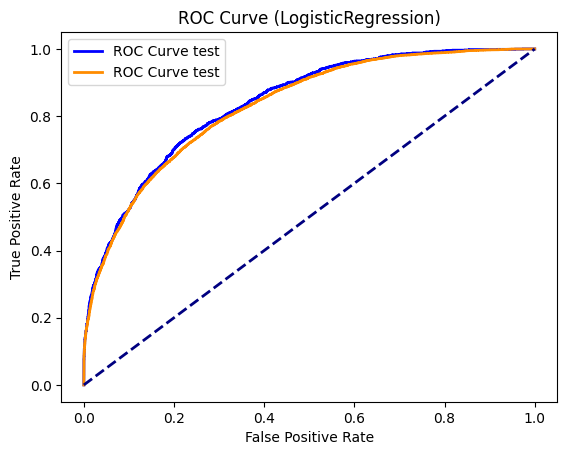

In [22]:
best_logreg_metrics = calculate_metrics_and_plot_roc(best_logreg_model, X_train_scaled, y_train, X_test_scaled, y_test)

In [23]:
best_logreg_metrics

{'params': ['Training_Precision',
  'Test_Precision',
  'Training_Recall',
  'Test_Recall',
  'roc_auc_train',
  'roc_auc_test'],
 'values': [0.550456179153995,
  0.5468085106382978,
  0.6350877192982456,
  0.6543602800763845,
  0.8302390667187277,
  0.8382608081884811]}

#Соберем все результаты в одну таблицу, чтобы было проще сравнивать алгоритмы

In [24]:
best_logreg_metrics['metrics'] = ['logreg' for i in range(6)]
metrics_knn['metrics'] = ['knn' for i in range(6)]

In [25]:
df_stat = pd.concat([
                    pd.DataFrame(best_logreg_metrics),
                    pd.DataFrame(metrics_knn)])

In [26]:
df_stat = df_stat.pivot_table(columns = 'params',
                            index='metrics',
                            values='values').reset_index()[['metrics','Test_Precision',	'Training_Precision',
                                                            'Test_Recall',	'Training_Recall',
                                                            'roc_auc_train', 'roc_auc_test']]

df_stat['dif_Precision'] = round((df_stat['Test_Precision'] - df_stat['Training_Precision'])/df_stat['Training_Precision'],2)
df_stat['dif_roc_auc'] = round((df_stat['roc_auc_test'] - df_stat['roc_auc_train'])/df_stat['roc_auc_train'],2)
df_stat['dif_Recall'] = round((df_stat['Test_Recall'] - df_stat['Training_Recall'])/df_stat['Training_Recall'],2)
df_stat

params,metrics,Test_Precision,Training_Precision,Test_Recall,Training_Recall,roc_auc_train,roc_auc_test,dif_Precision,dif_roc_auc,dif_Recall
0,knn,0.487500,0.561492,0.695099,0.799522,0.892794,0.812148,-0.13,-0.09,-0.13
1,logreg,0.546809,0.550456,0.654360,0.635088,0.830239,0.838261,-0.01,0.01,0.03


In [27]:
df_stat.T

,0,1
params,,
metrics,knn,logreg
Test_Precision,0.4875,0.546809
Training_Precision,0.561492,0.550456
Test_Recall,0.695099,0.65436
Training_Recall,0.799522,0.635088
roc_auc_train,0.892794,0.830239
roc_auc_test,0.812148,0.838261
dif_Precision,-0.13,-0.01
dif_roc_auc,-0.09,0.01
